# Importing Libraries

# Install CPU pytorch

In [1]:
#!pip install torch torchvision torchaudio

In [2]:
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import os

## Setting up global variables

In [3]:
# Setting Pytorch to GPU if Possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
data_path = os.path.dirname(os.getcwd()) + '/dataset'
trainset_path = data_path + '/train'
testset_path = data_path + '/test'

In [5]:
trainset_path

'C:\\Users\\richa\\PycharmProjects\\Cell-Images-Parasitized-or-Uninfected-Pytorch/dataset/train'

In [6]:
data_path

'C:\\Users\\richa\\PycharmProjects\\Cell-Images-Parasitized-or-Uninfected-Pytorch/dataset'

# Import Dataset and apply Augmentations

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64, 64)),
     transforms.Pad(6),
     transforms.RandomRotation(degrees=(0, 360))
    ])

batch_size = 64

trainset = torchvision.datasets.ImageFolder(
    root=trainset_path,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(
    root=testset_path,
    transform=transform
)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=3)

trainset.class_to_idx

{'parasitized': 0, 'uninfected': 1}

In [8]:
# Saving Dict to a list for later use
classes = list(trainset.class_to_idx)

In [9]:
classes

['parasitized', 'uninfected']

# Before agmentation

In [10]:
visual_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64, 64)),
#      transforms.Pad(6),
#      transforms.RandomRotation(degrees=(0, 360))
    ])

visualize_set = torchvision.datasets.ImageFolder(
    root=trainset_path,
    transform=visual_transform
)
visualize_loader = torch.utils.data.DataLoader(visualize_set, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

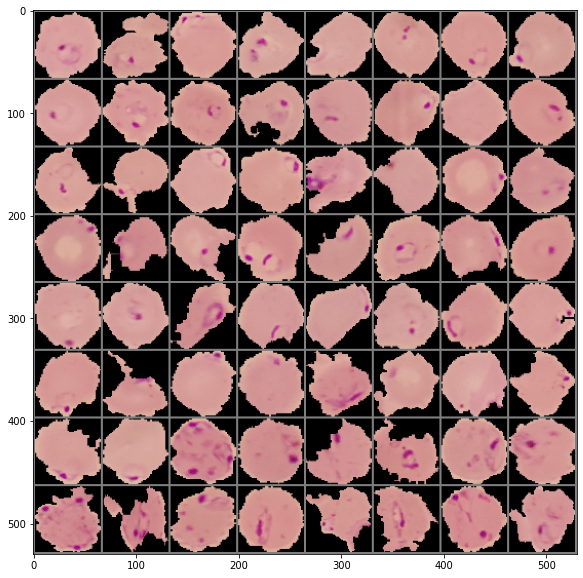

In [11]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(10, 10))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(visualize_loader)
images_vis, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_vis, 8))

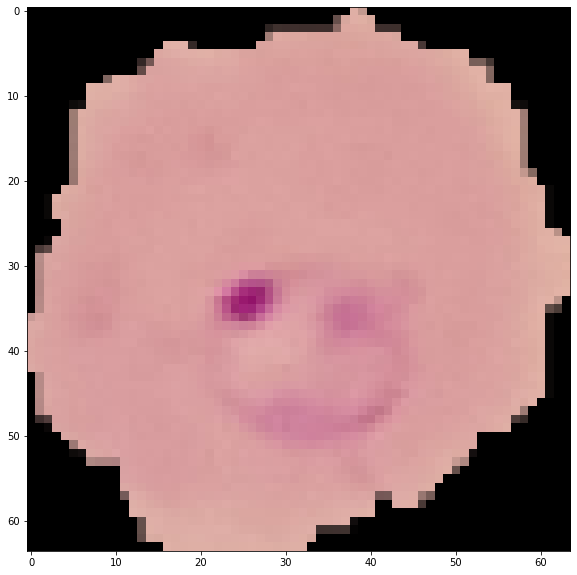

In [12]:
imshow(images_vis[0])

## Visualize data after agmentation

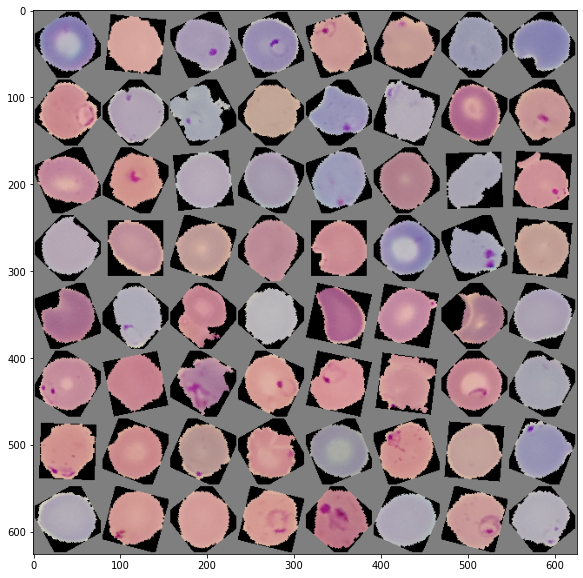

In [13]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(10, 10))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images, 8))

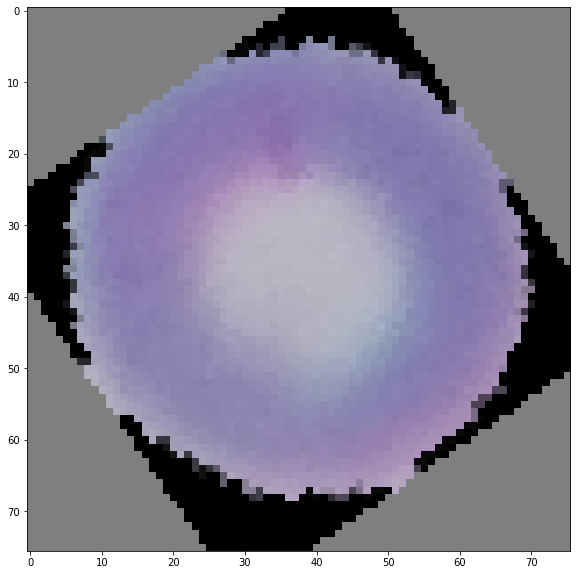

In [14]:
imshow(images[0])

In [15]:
images[0].shape

torch.Size([3, 76, 76])

# Creating the model

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,2)
        self.conv2 = nn.Conv2d(6,10,3)
#         self.fc1 = nn.Linear(184960, 10000)
        self.fc1 = nn.Linear(10 * 17 * 17, 10000)
        self.fc2 = nn.Linear(10000, 5000)
        self.fc3 = nn.Linear(5000, 2500)
        self.fc4 = nn.Linear(2500, 1500)
        self.fc5 = nn.Linear(1500, 750)
        self.fc6 = nn.Linear(750, len(classes))
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         x = torch.flatten(x)
#         print(x.shape)
#         x = x.view(-1, 184960)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
#         x = F.relu(self.fc6(x))
        x = self.fc6(x)
        return x
    
model = Model().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training model

In [18]:
total_loss = []

for epoch in range(8):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
       
        if i % 100 == 99:
            print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss / 100))
            total_loss.append(running_loss / 100)
            running_loss = 0.0

print('Finished Training')

[epoch, batch] =  [1,    99] loss: 0.671665
[epoch, batch] =  [1,   199] loss: 0.513734
[epoch, batch] =  [1,   299] loss: 0.251259
[epoch, batch] =  [2,    99] loss: 0.189295
[epoch, batch] =  [2,   199] loss: 0.202338
[epoch, batch] =  [2,   299] loss: 0.181147
[epoch, batch] =  [3,    99] loss: 0.183283
[epoch, batch] =  [3,   199] loss: 0.177376
[epoch, batch] =  [3,   299] loss: 0.146096
[epoch, batch] =  [4,    99] loss: 0.151716
[epoch, batch] =  [4,   199] loss: 0.157603
[epoch, batch] =  [4,   299] loss: 0.144082
[epoch, batch] =  [5,    99] loss: 0.140142
[epoch, batch] =  [5,   199] loss: 0.140915
[epoch, batch] =  [5,   299] loss: 0.142895
[epoch, batch] =  [6,    99] loss: 0.133235
[epoch, batch] =  [6,   199] loss: 0.133314
[epoch, batch] =  [6,   299] loss: 0.138592
[epoch, batch] =  [7,    99] loss: 0.138473
[epoch, batch] =  [7,   199] loss: 0.130271
[epoch, batch] =  [7,   299] loss: 0.146678
[epoch, batch] =  [8,    99] loss: 0.139016
[epoch, batch] =  [8,   199] los

# Graphing loss

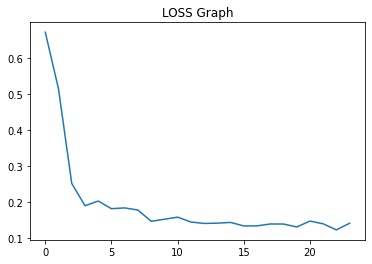

In [19]:
plt.plot(total_loss)
plt.title("LOSS Graph")
plt.show()

# Accuracy

In [20]:
correct = 0
total = 0

incorrect_predictions = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        extra_out, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        print(outputs)

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([[ 2.9669, -5.8607],
        [ 2.3550, -4.6664],
        [ 3.1640, -6.2670],
        [ 2.8548, -5.6579],
        [ 0.5146, -1.0208],
        [ 2.7100, -5.3801],
        [ 2.0563, -4.0708],
        [ 2.2258, -4.4170],
        [ 2.5748, -5.1016],
        [ 2.7511, -5.4511],
        [ 2.5576, -5.0618],
        [ 1.5208, -3.0129],
        [ 0.6004, -1.1869],
        [ 1.9476, -3.8629],
        [ 1.1581, -2.2969],
        [ 2.2758, -4.5092],
        [ 4.1173, -8.1226],
        [ 1.7596, -3.4912],
        [ 2.3796, -4.7215],
        [ 2.9052, -5.7576],
        [ 0.7113, -1.4107],
        [ 3.3989, -6.7308],
        [ 1.6330, -3.2332],
        [ 3.6214, -7.1769],
        [ 3.4831, -6.9189],
        [ 2.6865, -5.3241],
        [ 1.3584, -2.6942],
        [ 2.0214, -4.0036],
        [ 0.7990, -1.5826],
        [ 2.6471, -5.2491],
        [ 2.8923, -5.7193],
        [ 2.4695, -4.8807],
        [ 1.6007, -3.1711],
        [-1.1365,  0.9738],
        [ 2.8941, -5.7306],
        [ 2.4007, -4

tensor([[  1.6872,  -3.3457],
        [  1.7714,  -3.5167],
        [  2.2035,  -4.3692],
        [  1.3722,  -2.7169],
        [  1.8450,  -3.6522],
        [  1.5375,  -3.0472],
        [  2.6189,  -5.1934],
        [  3.6205,  -7.1855],
        [  3.0542,  -6.0503],
        [  2.6974,  -5.3427],
        [  1.2109,  -2.4046],
        [  1.0896,  -2.1622],
        [  0.9622,  -1.9080],
        [  0.9671,  -1.9122],
        [  1.7078,  -3.3809],
        [  1.4343,  -2.8335],
        [  2.0241,  -4.0138],
        [  0.6893,  -1.3648],
        [  1.0607,  -2.1026],
        [  1.2414,  -2.4584],
        [  2.1830,  -4.3334],
        [  1.6475,  -3.2637],
        [  2.5331,  -5.0174],
        [  2.5235,  -5.0199],
        [  0.9156,  -1.8168],
        [  1.5825,  -3.1323],
        [ -1.1520,   0.9777],
        [  0.3832,  -0.7582],
        [  2.2063,  -4.3661],
        [  1.1503,  -2.2802],
        [  2.0308,  -4.0176],
        [  2.0403,  -4.0386],
        [  1.5114,  -2.9918],
        [ 

tensor([[ 1.7819, -3.5370],
        [-2.1191,  1.8681],
        [ 1.4166, -2.8056],
        [ 1.8552, -3.6767],
        [ 1.5207, -3.0111],
        [ 1.5506, -3.0735],
        [ 1.8563, -3.6906],
        [ 1.3051, -2.5821],
        [ 2.0257, -4.0165],
        [ 2.0084, -3.9897],
        [ 2.5405, -5.0371],
        [ 2.0739, -4.1075],
        [ 1.1441, -2.2693],
        [ 2.0917, -4.1370],
        [ 3.3501, -6.6490],
        [ 0.6426, -1.2755],
        [ 1.5298, -3.0343],
        [ 1.8306, -3.6366],
        [ 2.1757, -4.3168],
        [ 1.1861, -2.3482],
        [ 2.9896, -5.9266],
        [ 0.8475, -1.6806],
        [ 3.6102, -7.1540],
        [ 1.9648, -3.8915],
        [ 2.5368, -5.0233],
        [ 1.2573, -2.4902],
        [ 1.0703, -2.1196],
        [ 2.2758, -4.5161],
        [ 3.2646, -6.4770],
        [ 0.3671, -0.7244],
        [ 2.0535, -4.0812],
        [ 1.7143, -3.3980],
        [ 1.6882, -3.3609],
        [ 1.8008, -3.5643],
        [-0.4571,  0.3758],
        [ 2.2020, -4

tensor([[ 2.2437, -4.4543],
        [ 0.8927, -1.7697],
        [ 2.0171, -3.9911],
        [ 2.5170, -4.9866],
        [ 0.2737, -0.5383],
        [ 0.9753, -1.9286],
        [ 1.8825, -3.7374],
        [ 2.0374, -4.0400],
        [ 2.0320, -4.0308],
        [ 1.9515, -3.8624],
        [ 1.5947, -3.1599],
        [ 0.7516, -1.4930],
        [ 1.4560, -2.8815],
        [-1.0895,  0.9461],
        [ 1.3653, -2.7101],
        [ 0.7068, -1.4042],
        [ 0.9968, -1.9784],
        [-1.3428,  1.1705],
        [ 2.2974, -4.5539],
        [ 2.4456, -4.8458],
        [ 1.4618, -2.8998],
        [ 1.7165, -3.4077],
        [ 1.9906, -3.9382],
        [ 0.9843, -1.9521],
        [ 1.3771, -2.7310],
        [-1.6257,  1.4142],
        [ 0.6401, -1.2655],
        [ 1.1618, -2.3010],
        [ 1.1191, -2.2213],
        [ 0.6636, -1.3160],
        [ 1.1985, -2.3753],
        [ 1.2377, -2.4538],
        [ 1.3143, -2.6024],
        [ 3.9031, -7.7399],
        [-2.0509,  1.8116],
        [ 1.9397, -3

tensor([[-2.5988,  2.3055],
        [-1.9126,  1.6902],
        [-2.7333,  2.4253],
        [-2.7711,  2.4565],
        [-3.1750,  2.8206],
        [-1.3059,  1.1376],
        [-1.9799,  1.7479],
        [-1.7126,  1.5126],
        [-2.3128,  2.0501],
        [-2.4915,  2.2102],
        [-1.7573,  1.5526],
        [-2.3666,  2.0974],
        [-2.6923,  2.3892],
        [-1.8286,  1.6131],
        [ 0.2667, -0.5303],
        [-3.1308,  2.7811],
        [-1.9123,  1.6914],
        [-1.9555,  1.7302],
        [-1.8003,  1.5908],
        [-2.7403,  2.4314],
        [-2.5650,  2.2760],
        [-3.3609,  2.9875],
        [-2.5997,  2.3069],
        [-2.8366,  2.5190],
        [-2.2814,  2.0217],
        [-2.8653,  2.5409],
        [-2.3909,  2.1199],
        [-2.4691,  2.1899],
        [-2.5486,  2.2607],
        [-2.4376,  2.1180],
        [-1.5790,  1.3414],
        [ 0.1542, -0.3083],
        [-1.2708,  1.0875],
        [ 1.4784, -2.9277],
        [ 1.3282, -2.6307],
        [-1.3883,  1

tensor([[-2.6521,  2.3532],
        [-3.1655,  2.8121],
        [-2.2290,  1.9736],
        [-2.4946,  2.2123],
        [-2.0102,  1.7780],
        [-1.6642,  1.4653],
        [-2.2860,  2.0244],
        [-2.8295,  2.5124],
        [-1.0135,  0.8722],
        [-2.4136,  2.1387],
        [-2.2873,  2.0236],
        [-2.1386,  1.8931],
        [-2.4882,  2.2068],
        [-1.7792,  1.5657],
        [-1.7924,  1.5800],
        [-4.1032,  3.6467],
        [-2.9514,  2.6167],
        [-2.0364,  1.8010],
        [-1.5510,  1.3617],
        [-1.5497,  1.3575],
        [-1.9453,  1.7161],
        [-1.5514,  1.3588],
        [-1.7282,  1.5245],
        [-2.5571,  2.2677],
        [-1.4840,  1.3058],
        [-2.4795,  2.1990],
        [-2.2964,  2.0344],
        [-2.8703,  2.5494],
        [-3.3369,  2.9664],
        [-3.2861,  2.9203],
        [-3.1863,  2.8317],
        [-2.3661,  2.0977],
        [-3.8315,  3.4082],
        [-5.1383,  4.5747],
        [-3.0702,  2.7262],
        [-1.5974,  1

tensor([[-2.9154,  2.5881],
        [-2.2237,  1.9682],
        [-2.5927,  2.2996],
        [-1.6545,  1.4577],
        [-1.6503,  1.4565],
        [-2.7779,  2.4659],
        [-0.7423,  0.6239],
        [-3.1190,  2.7712],
        [-2.4334,  2.1574],
        [-1.5775,  1.3892],
        [-1.5792,  1.3917],
        [-1.9799,  1.7507],
        [-2.2612,  2.0002],
        [-2.5276,  2.2424],
        [-2.8109,  2.4942],
        [-1.7102,  1.5098],
        [-1.6428,  1.4462],
        [-2.8185,  2.5001],
        [-1.1272,  0.9726],
        [-1.3128,  1.1523],
        [-2.7888,  2.4756],
        [-1.7900,  1.5817],
        [-1.2357,  1.0792],
        [-1.9933,  1.7633],
        [-2.3040,  2.0418],
        [-2.8922,  2.5685],
        [-2.3639,  2.0954],
        [ 0.2940, -0.5854],
        [-1.7312,  1.5287],
        [-2.8125,  2.4972],
        [-2.5621,  2.2727],
        [-3.5001,  3.1117],
        [ 0.2187, -0.4311],
        [-2.1288,  1.8818],
        [-1.8408,  1.6250],
        [-2.4375,  2

Accuracy of the network on the test images: 95 %


In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels.to(device), predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class parasitized is: 93.8 %
Accuracy for class uninfected is: 96.8 %
